# calc_variogram.pyのリファクタリング

In [17]:
import calc_variogram as cal_vario
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [47]:
%load_ext autoreload
%autoreload 2

実際に利用するデータを使用

In [80]:
data = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_raw.csv')

In [81]:
data.head()

,px,py,price,station,tokyo
0,139.362310,35.733850,153000.0,0.010620,0.408220
1,139.363027,35.654078,172000.0,0.011653,0.405010
2,139.367082,35.659859,217000.0,0.010110,0.400614
3,139.369003,35.645546,173000.0,0.004172,0.399719
4,139.371526,35.647323,165000.0,0.007247,0.397050


距離に比してzの値が大きい場合はlogをとる or 正規化して修正しないと最適化できない

In [82]:
data['price'] = np.log(data.price)

In [83]:
data = data[['px', 'py', 'price']].values

In [84]:
data

array([[139.36231   ,  35.73385   ,  11.9381932 ],
       [139.363027  ,  35.654078  ,  12.05524976],
       [139.367082  ,  35.659859  ,  12.28765263],
       [139.369003  ,  35.645546  ,  12.06104687],
       [139.371526  ,  35.647323  ,  12.01370075],
       [139.373562  ,  35.727595  ,  12.15477935],
       [139.374415  ,  35.673241  ,  12.14950229],
       [139.374691  ,  35.653972  ,  12.23076526],
       [139.375802  ,  35.662974  ,  12.4874851 ],
       [139.377419  ,  35.668593  ,  12.41714362],
       [139.379504  ,  35.678973  ,  12.18075484],
       [139.379862  ,  35.681658  ,  12.01974307],
       [139.380375  ,  35.654424  ,  12.34147728],
       [139.380871  ,  35.722007  ,  12.03171926],
       [139.382431  ,  35.648601  ,  12.14950229],
       [139.382461  ,  35.653061  ,  12.23076526],
       [139.385678  ,  35.671431  ,  12.35879373],
       [139.385702  ,  35.647797  ,  12.13350195],
       [139.387019  ,  35.678619  ,  12.1388639 ],
       [139.387149  ,  35.72655

In [85]:
vario = cal_vario.get_diff(data)

In [86]:
vario

array([[0.07977522, 0.07414472, 0.08855728, ..., 0.00499936, 0.01262236,
        0.00762327],
       [0.00685112, 0.06106095, 0.00754651, ..., 0.0230388 , 0.00582001,
        0.0056997 ]])

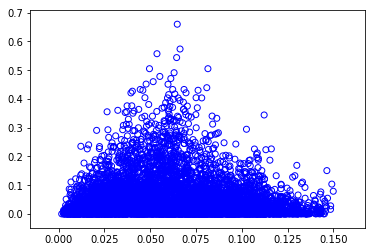

In [87]:
plt.scatter(vario[0], vario[1], facecolors='None', edgecolors='blue')

In [88]:
vario.shape

(2, 8128)

In [45]:
def emp_variogram(z_vario, lag_h):
    '''
    calculate empirical variogram
    input: difference of spatial (2, nC2)matrix,  bandwith of bins
    '''
    bin_means, bin_edges, bin_number = stats.binned_statistic(z_vario[0], z_vario[1], statistic='mean', bins=lag_h)
    # bin_edgesに関しては最初のものを省く
    print(bin_means)
    e_vario = np.stack([bin_edges[1:], bin_means[0:]], axis=0)
    e_vario = np.delete(e_vario, np.where(e_vario[1] <= 0), axis=1)

    return e_vario

In [89]:
e_vario = cal_vario.emp_variogram(vario, 5)

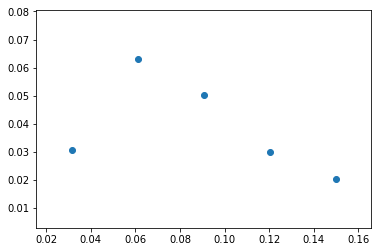

In [90]:
plt.scatter(e_vario[0], e_vario[1])

In [93]:
param = cal_vario.auto_fit(e_vario, 10, 1)

In [94]:
print(param)

[ 1.00000000e+00  1.00000000e+01  5.11932966e-02 -2.23436200e+02
  1.34342683e+01]


[0.         0.0183234  0.0366468  0.0549702  0.0732936  0.09161699
 0.10994039 0.12826379 0.14658719 0.16491059]
[0.         0.0183234  0.0366468  0.0549702  0.0732936  0.09161699
 0.10994039 0.12826379 0.14658719 0.16491059] -223.4362003816889 13.4342683160516


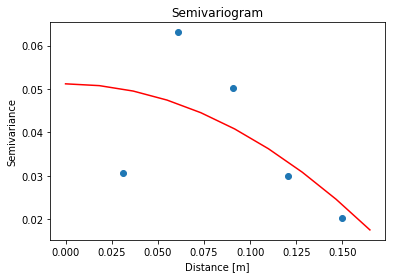

In [95]:
fig = cal_vario.plot_semivario(e_vario, param)

[ 0.00000000e+00  1.00000000e+02  5.53698639e-02 -1.82289447e-01]
liner:0.007838675158340115
[ 1.00000000e+00  1.00000000e+02  5.11931744e-02 -1.24378900e+04
  1.00235640e+02]
gaussian:0.008005686099929202
[ 2.00000000e+00  1.00000000e+02  5.53698247e-02 -1.44647685e+02
  7.93450917e+02]
exponent:0.00783863657561588
[ 3.00000000e+00  1.00000000e+02  5.53698652e-02 -1.21843130e+01
  1.00260658e+02]
spherical:0.00783867493139711
[0.         0.0183234  0.0366468  0.0549702  0.0732936  0.09161699
 0.10994039 0.12826379 0.14658719 0.16491059]
0.055369824662103315 -144.64768544812955 793.4509174630683


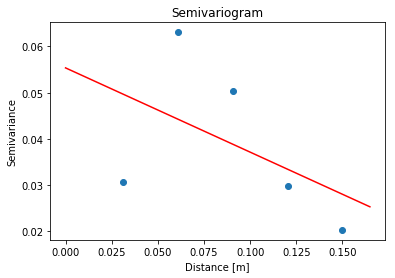

In [96]:
param, res, fig = cal_vario.choose_model(e_vario)

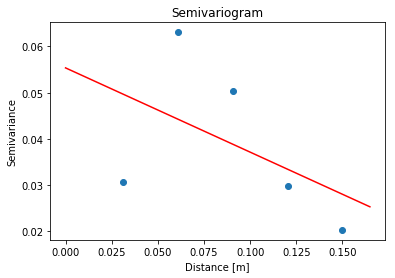

In [98]:
fig

[0.         0.0183234  0.0366468  0.0549702  0.0732936  0.09161699
 0.10994039 0.12826379 0.14658719 0.16491059]
0.055369824662103315 -144.64768544812955 793.4509174630683


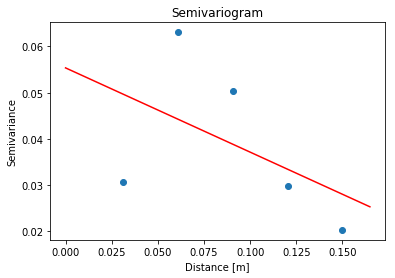

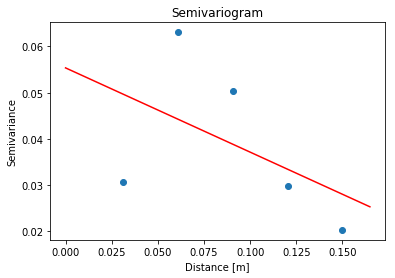

In [99]:
cal_vario.plot_semivario(e_vario, param)

In [100]:
print(param)

[ 2.00000000e+00  1.00000000e+02  5.53698247e-02 -1.44647685e+02
  7.93450917e+02]


[ 0.00000000e+00  1.00000000e+02  5.89736207e-02 -1.83790169e-01]
liner:0.005086046686213257
[ 1.00000000e+00  1.00000000e+02  5.26213104e-02 -1.03718749e+04
  1.00188060e+02]
gaussian:0.0051360110678033595
[ 2.00000000e+00  1.00000000e+02  5.89739458e-02 -3.49128703e+02
  1.89951513e+03]
exponent:0.005086049629238159
[ 3.00000000e+00  1.00000000e+02  5.89736264e-02 -1.22791063e+01
  1.00215613e+02]
spherical:0.0050860465927300424
[0.         0.0183234  0.0366468  0.0549702  0.0732936  0.09161699
 0.10994039 0.12826379 0.14658719 0.16491059]
0.0589736264397169 -12.279106275027962 100.21561327672558
[ 3.00000000e+00  1.00000000e+02  5.89736264e-02 -1.22791063e+01
  1.00215613e+02]
[ 0.00000000e+00  1.00000000e+02  5.84786842e-02 -2.06989728e-01]
liner:0.006363635204992632
[ 1.00000000e+00  1.00000000e+02  5.26828096e-02 -1.30158423e+04
  1.00315102e+02]
gaussian:0.00649093041517213
[ 2.00000000e+00  1.00000000e+02  5.84788039e-02 -3.18909463e+02
  1.54064512e+03]
exponent:0.006363656192

/Users/LOng/.local/share/virtualenvs/LDAT_LS_2019-qp6Uijrp/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.         0.0183234  0.0366468  0.0549702  0.0732936  0.09161699
 0.10994039 0.12826379 0.14658719 0.16491059]
0.05221871663996601 -11.184002625708697 100.32725131725063
[ 3.00000000e+00  1.00000000e+02  5.22187166e-02 -1.11840026e+01
  1.00327251e+02]
[ 0.00000000e+00  1.00000000e+02  5.16682460e-02 -1.60542292e-01]
liner:0.015143101376389074
[ 1.00000000e+00  1.00000000e+02  4.93874673e-02 -1.25920536e+04
  9.96542890e+01]
gaussian:0.015524100338134398
[ 2.00000000e+00  1.00000000e+02  5.16678175e-02 -1.18421968e+02
  7.37613720e+02]
exponent:0.01514310002009474
[ 3.00000000e+00  1.00000000e+02  5.16682444e-02 -1.07392424e+01
  1.00340282e+02]
spherical:0.015143100934720011
[0.         0.0183234  0.0366468  0.0549702  0.0732936  0.09161699
 0.10994039 0.12826379 0.14658719 0.16491059]
0.051667817493650056 -118.42196786312371 737.613719816691
[ 2.00000000e+00  1.00000000e+02  5.16678175e-02 -1.18421968e+02
  7.37613720e+02]


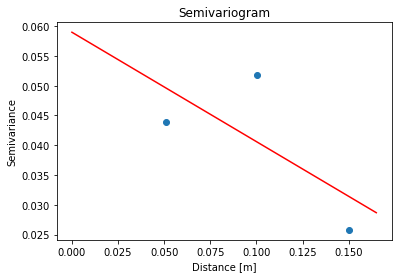

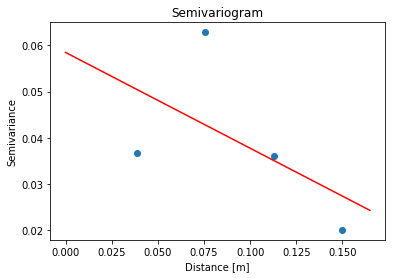

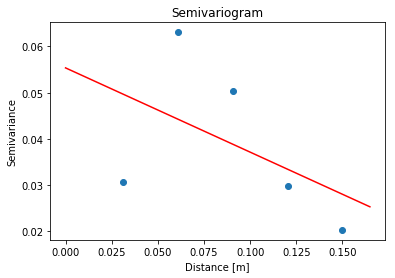

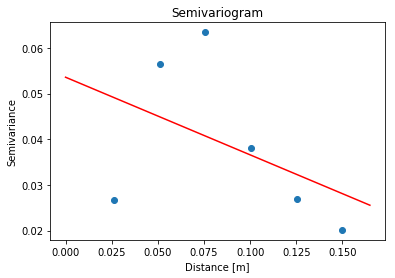

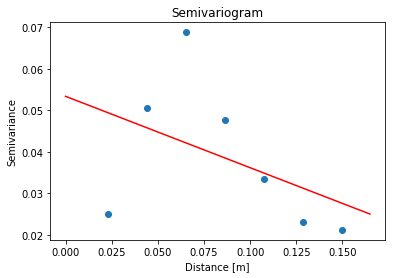

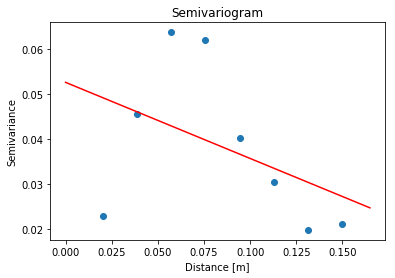

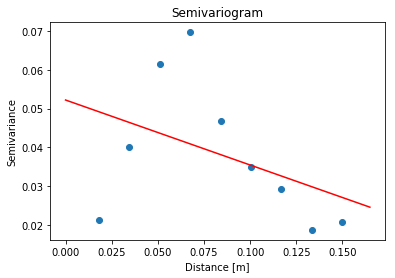

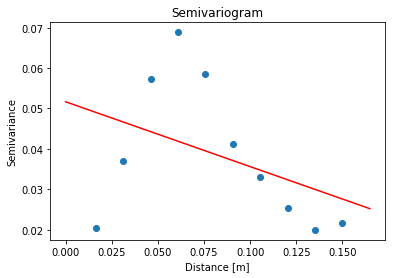

In [104]:
param, lag_num, fig = cal_vario.auto_vario(vario, range(5,13))

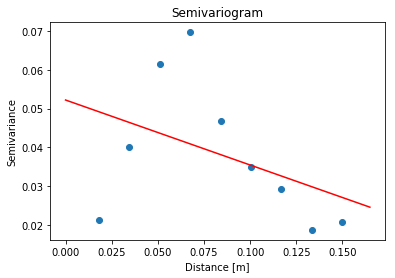

In [105]:
fig